In [1]:
!pip install wfdb numpy matplotlib scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 59.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


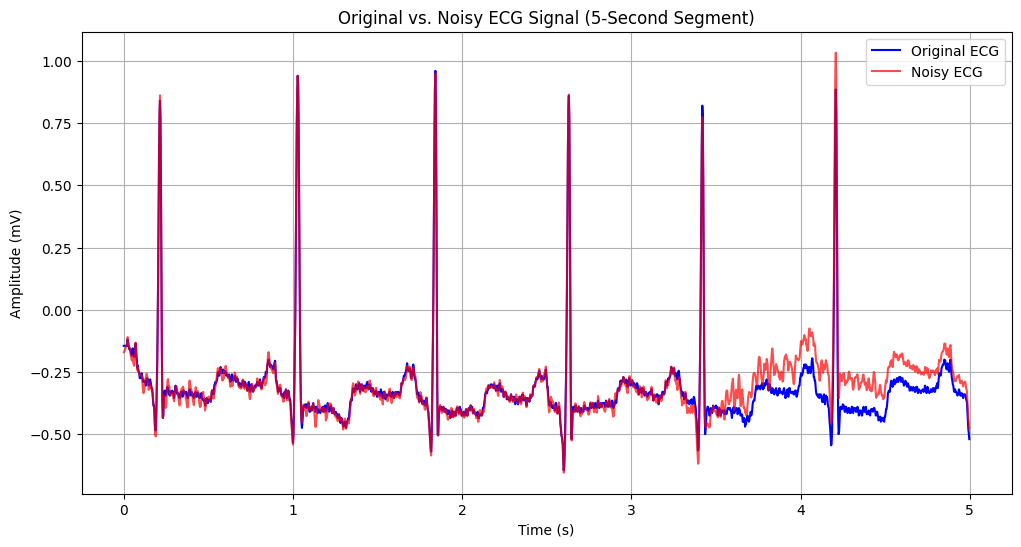

Signals loaded and combined successfully.


In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# 2.1 Load ECG signal from the MIT-BIH Arrhythmia Database
# We'll use record 100 as an example.
# The `pn_dir` parameter specifies the PhysioNet project and version.
ecg_record_name = '100'
ecg_record = wfdb.rdrecord(ecg_record_name, pn_dir='mitdb/1.0.0/')
ecg_signal = ecg_record.p_signal[:, 0]
fs = ecg_record.fs # Sampling frequency in Hz

# 2.2 Load noise signal from the MIT-BIH Noise Stress Test Database
# We'll use record "ma" (muscle artifact) as it represents high-frequency noise.
noise_record_name = 'ma'
noise_record = wfdb.rdrecord(noise_record_name, pn_dir='nstdb/1.0.0/')
noise_signal = noise_record.p_signal[:, 0]

# Ensure the signals have the same length for addition
# Take a segment of the ECG signal and a segment of the noise signal of equal length.
segment_length = 5 * fs # 5 seconds of data
ecg_segment = ecg_signal[:segment_length]
noise_segment = noise_signal[:segment_length]

# Normalize the noise to a reasonable level relative to the ECG signal
# This scales the noise so it's visible without completely overwhelming the ECG.
noise_segment_scaled = noise_segment / np.max(np.abs(noise_segment)) * np.std(ecg_segment)

# 2.3 Create the noisy signal by adding noise to the ECG segment
noisy_ecg_signal = ecg_segment + noise_segment_scaled

# Create a time array for plotting
time = np.arange(noisy_ecg_signal.size) / fs

# Now we can plot the original and noisy signals to see the effect
plt.figure(figsize=(12, 6))
plt.plot(time, ecg_segment, label='Original ECG', color='blue')
plt.plot(time, noisy_ecg_signal, label='Noisy ECG', color='red', alpha=0.7)
plt.title('Original vs. Noisy ECG Signal (5-Second Segment)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True)
plt.show()

print("Signals loaded and combined successfully.")


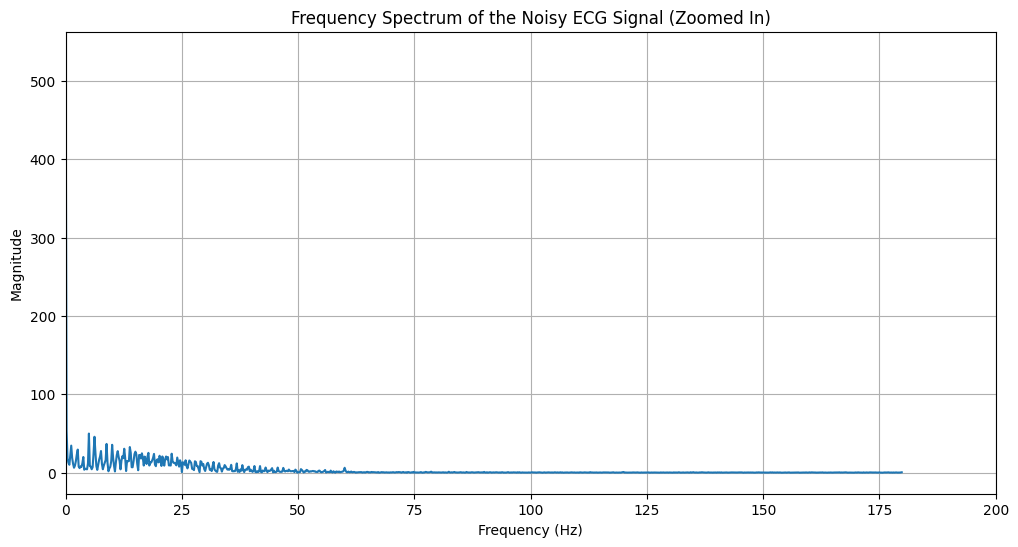

Fourier Transform applied and frequency spectrum plotted successfully.


In [5]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import numpy as np

# This code assumes the variables `noisy_ecg_signal` and `fs`
# were created in the previous step and are available in the notebook's environment.
# If you are running this in a new session, you will need to re-run the previous cells.

# 3.1 Apply the Fast Fourier Transform (FFT)
N = noisy_ecg_signal.size # Number of data points
yf = fft(noisy_ecg_signal) # Apply the FFT to the noisy signal
xf = fftfreq(N, 1 / fs) # Generate the frequency bins for plotting

# 3.2 Plot the frequency spectrum with a zoomed-in view
plt.figure(figsize=(12, 6))
# We plot the magnitude of the FFT and only show the positive frequencies
plt.plot(xf[:N//2], np.abs(yf[:N//2]))
plt.title('Frequency Spectrum of the Noisy ECG Signal (Zoomed In)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 200) # Limit the x-axis to a more focused range (0-200 Hz)
plt.show()

print("Fourier Transform applied and frequency spectrum plotted successfully.")

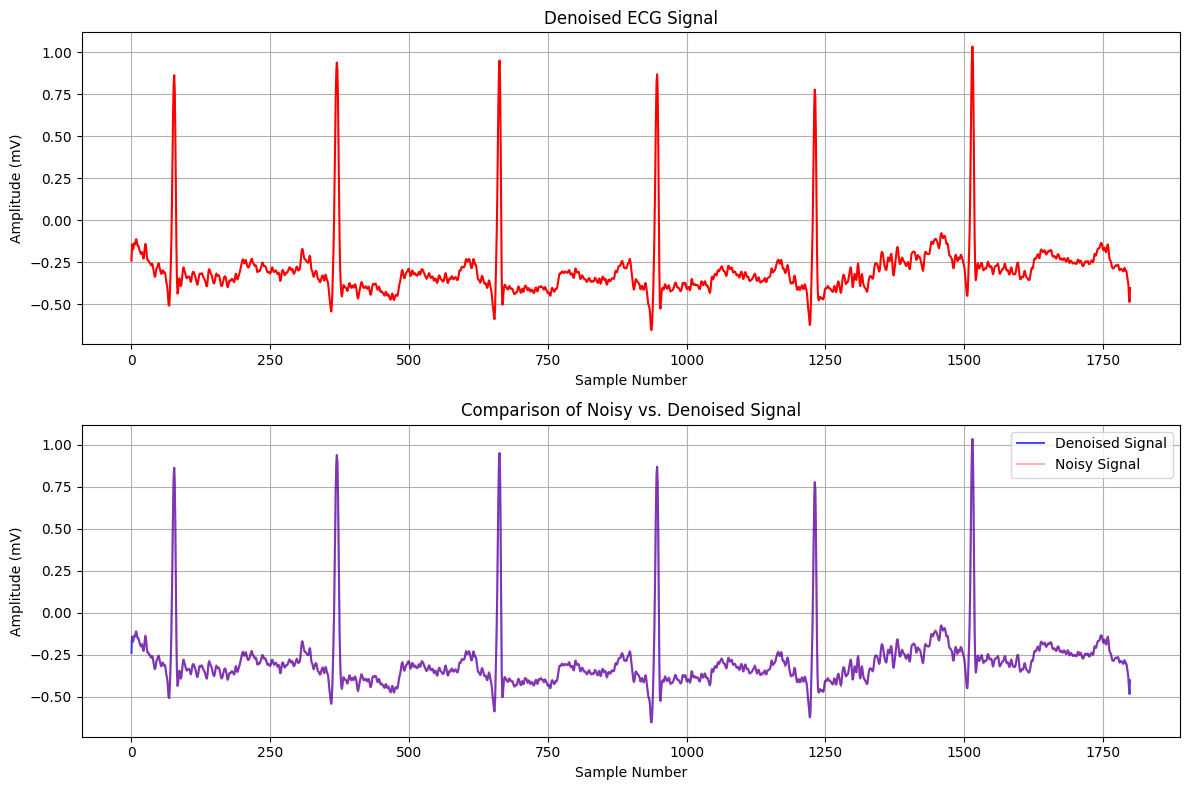

Signal successfully filtered and denoised.


In [6]:
from scipy.fft import ifft
import numpy as np
import matplotlib.pyplot as plt

# This code assumes the variables `yf`, `xf`, and `N`
# were created in the previous step and are available in the notebook's environment.
# If you are running this in a new session, you will need to re-run the previous cells.

# 4.1 Define the filter and apply it
# We'll apply a simple "ideal" low-pass filter
# First, find the indices where the frequency is above our cutoff.
# A cutoff of 100 Hz is a good starting point for ECG signals.
cutoff_frequency = 100 # in Hz
indices = np.abs(xf) > cutoff_frequency

# Zero out all frequency components above the cutoff
yf_filtered = yf.copy()
yf_filtered[indices] = 0

# 4.2 Apply the Inverse Fast Fourier Transform (IFFT)
# This converts the signal back from the frequency domain to the time domain.
# We take the real part of the result because the IFFT output can have
# a very small imaginary component due to floating-point errors.
denoised_ecg_signal = ifft(yf_filtered).real

# 4.3 Plot the results
# We'll plot the noisy and denoised signals to compare them.
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(denoised_ecg_signal, color='red')
plt.title('Denoised ECG Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (mV)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(denoised_ecg_signal, label='Denoised Signal', color='blue', alpha=0.7)
plt.plot(noisy_ecg_signal, label='Noisy Signal', color='red', alpha=0.3)
plt.title('Comparison of Noisy vs. Denoised Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjusts plots to prevent overlap
plt.show()

print("Signal successfully filtered and denoised.")


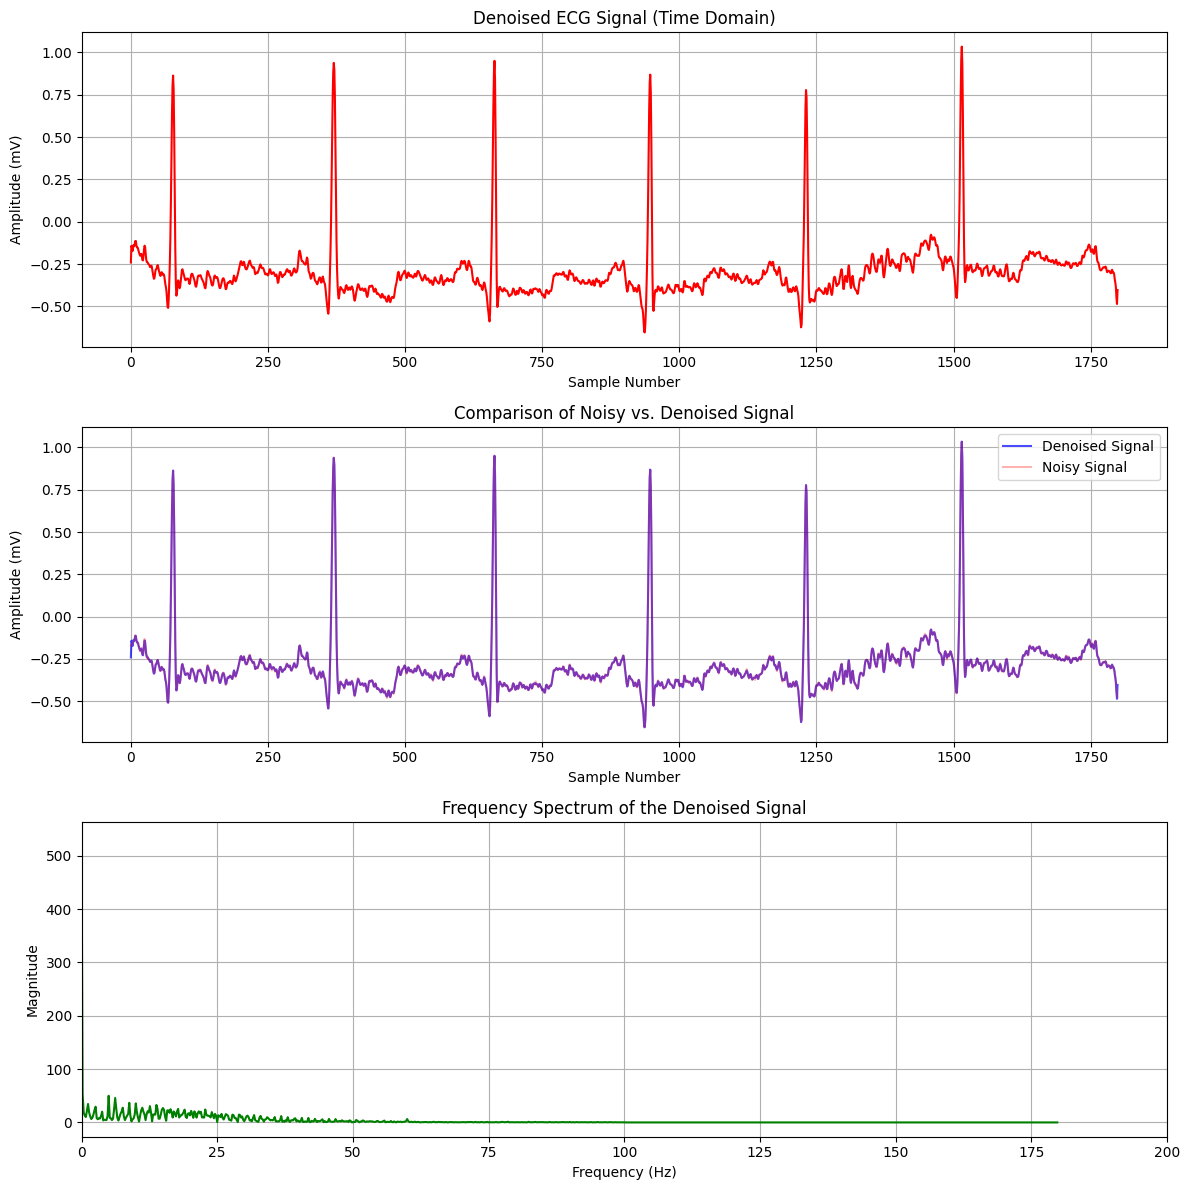

Signal successfully filtered and denoised. Added a plot of the denoised frequency spectrum.


In [7]:
from scipy.fft import ifft
import numpy as np
import matplotlib.pyplot as plt

# This code assumes the variables `yf`, `xf`, and `N`
# were created in the previous step and are available in the notebook's environment.
# If you are running this in a new session, you will need to re-run the previous cells.

# 4.1 Define the filter and apply it
# We'll apply a simple "ideal" low-pass filter
# First, find the indices where the frequency is above our cutoff.
# A cutoff of 100 Hz is a good starting point for ECG signals.
cutoff_frequency = 100 # in Hz
indices = np.abs(xf) > cutoff_frequency

# Zero out all frequency components above the cutoff
yf_filtered = yf.copy()
yf_filtered[indices] = 0

# 4.2 Apply the Inverse Fast Fourier Transform (IFFT)
# This converts the signal back from the frequency domain to the time domain.
# We take the real part of the result because the IFFT output can have
# a very small imaginary component due to floating-point errors.
denoised_ecg_signal = ifft(yf_filtered).real

# 4.3 Plot the results
# We'll plot the noisy and denoised signals and the denoised frequency spectrum.
plt.figure(figsize=(12, 12))

# Subplot 1: Denoised Signal in the time domain
plt.subplot(3, 1, 1)
plt.plot(denoised_ecg_signal, color='red')
plt.title('Denoised ECG Signal (Time Domain)')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (mV)')
plt.grid(True)

# Subplot 2: Comparison of Noisy vs. Denoised Signal (Time Domain)
plt.subplot(3, 1, 2)
plt.plot(denoised_ecg_signal, label='Denoised Signal', color='blue', alpha=0.7)
plt.plot(noisy_ecg_signal, label='Noisy Signal', color='red', alpha=0.3)
plt.title('Comparison of Noisy vs. Denoised Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True)

# Subplot 3: Denoised Signal in the frequency domain
plt.subplot(3, 1, 3)
plt.plot(xf[:N//2], np.abs(yf_filtered[:N//2]), color='green')
plt.title('Frequency Spectrum of the Denoised Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 200) # Zoom in to show the effect of the filter
plt.tight_layout() # Adjusts plots to prevent overlap
plt.show()

print("Signal successfully filtered and denoised. Added a plot of the denoised frequency spectrum.")

